<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-plot" data-toc-modified-id="Simple-plot-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple plot</a></span></li><li><span><a href="#With-variable-dependencies" data-toc-modified-id="With-variable-dependencies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>With variable dependencies</a></span></li><li><span><a href="#3-d-plot" data-toc-modified-id="3-d-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>3-d plot</a></span></li><li><span><a href="#Multi-plot-with-3-d-plots" data-toc-modified-id="Multi-plot-with-3-d-plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multi plot with 3-d plots</a></span></li><li><span><a href="#With-confidence-interval" data-toc-modified-id="With-confidence-interval-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>With confidence interval</a></span></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cartesian_explorer import Explorer
import time

%load_ext autoreload
%autoreload 2

In [2]:
ex = Explorer(parallel='thread')

## Simple plot

<ipython-input-3-21713d068624>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(np.exp((E-.5)/T) + 1)


Text(0.5, 1.0, 'Fermi-Dirac distribution')

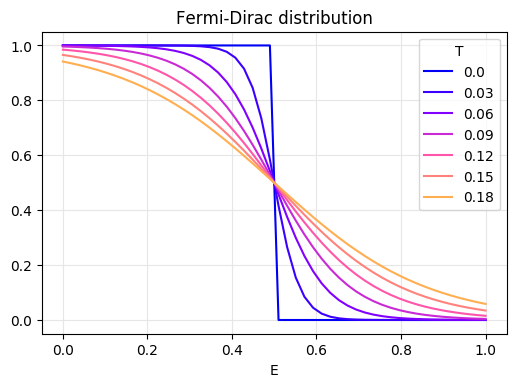

In [3]:
def Electrons(T, E):
    return 1/(np.exp((E-.5)/T) + 1)

_ = ex.plot2d(Electrons, T=.03*np.arange(7), E=np.linspace(0, 1))
plt.title('Fermi-Dirac distribution')

## With variable dependencies


Cartesian explorer thinks of your functions as variables that depend on other variables.
If you call `plot_variables2d`, `Explorer` will automatically resolve all required variables from functions that you provided.

You can explicitly specify what variable to use for a particular function input with `ex.add_function`.
All functions that are required to calculate the result will be found and called to obtain the intermediary data.

In [4]:
ex = Explorer()

@ex.add_function(provides='Mass', requires=('time_sec', 'T'))
def mass(time_sec, T):
    return np.exp(-T*time_sec)

@ex.add_function(provides='Speed', requires=('time_sec', 'T'))
def speed(time_sec, T):
    return -T*np.exp(-T*time_sec)

@ex.provider
def T(isotope):
    if isotope == 'Pb186':
        return np.log(2)/4.82
    if isotope == 'Pb187':
        return np.log(2)/15.2

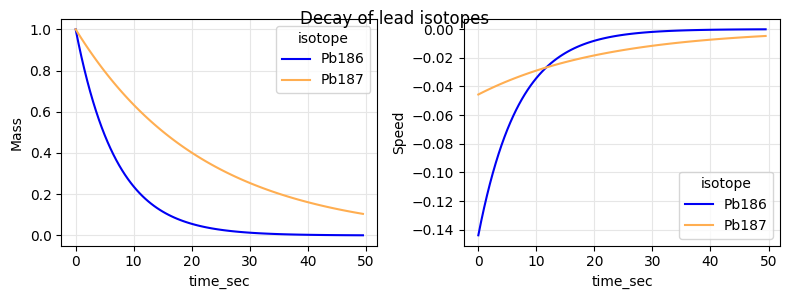

In [5]:
fig = ex.plot_variables2d(('Mass', 'Speed'),
                           isotope=['Pb186', 'Pb187'],
                           time_sec=np.arange(100)/2
                    )
fig.suptitle('Decay of lead isotopes')
plt.tight_layout()

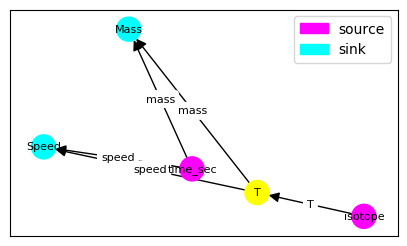

In [6]:
_ = ex.draw_dependency_graph(figsize=(5, 3))

## 3-d plot

In [7]:
ex2 = Explorer()

@ex2.add_function(provides='compl', requires=('Re', 'Im'))
def comp_val(Re, Im):
    return Re + 1j*Im

@ex2.add_function(provides='zval', requires='compl')
def get_zval(compl):
    return np.sin(compl)


/home/plate/.local/lib/python3.8/site-packages/numpy/ma/core.py:2794: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


Text(0.5, 1.0, 'sin(z)')

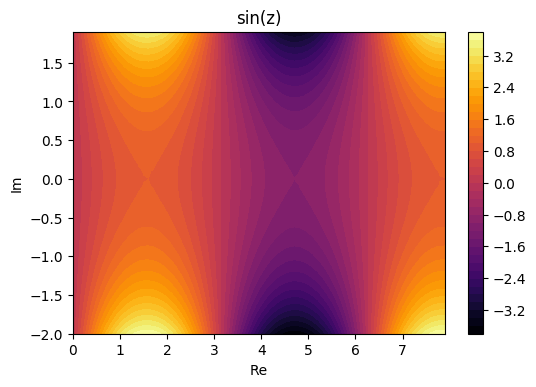

In [8]:
fig = ex2.plot_variables3d('zval', 
                     plot_kwargs=dict(levels=40, cmap='inferno'),
                     Im=np.arange(-20, 20)/10, Re=np.arange(0,80)/10,
                    )
plt.title('sin(z)')

## Multi plot with 3-d plots

In [9]:
ex3 = Explorer()

@ex3.add_function(provides='compl', requires=('Re', 'Im'))
def comp_val(Re, Im):
    return Re + 1j*Im

@ex3.provider
def sinz(compl):
    return np.sin(compl)

@ex3.add_function(provides='Joukowsky', requires='compl')
def J(compl):
    compl *= 2
    return compl + 1/compl

<ipython-input-9-4601abd6bb5b>:14: RuntimeWarning: divide by zero encountered in cdouble_scalars
  return compl + 1/compl
<ipython-input-9-4601abd6bb5b>:14: RuntimeWarning: invalid value encountered in cdouble_scalars
  return compl + 1/compl


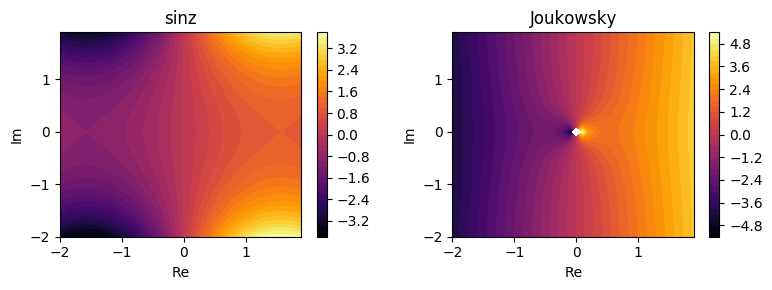

In [10]:
fig = ex3.plot_variables3d(('sinz', 'Joukowsky'),
                     plot_kwargs=dict(levels=40, cmap='inferno'),
                     Im=np.arange(-20, 20)/10, Re=np.arange(-20, 20)/10,
                    )
plt.tight_layout()

In [11]:
ex3.get_provided()

['compl', 'sinz', 'Joukowsky']

## With confidence interval

In [12]:
ex4 = Explorer()

In [13]:
@ex4.provider
def cooktop_power(oven_type):
    return {'gas': 12, 'electric': 15}[oven_type]

@ex4.provider
def denaturation_time(meat_type):
    return {'beef': 15, 'salmon':10}[meat_type]

@ex4.provider
def thermal_conductivity(meat_type):
    return {'beef':5, 'salmon':7}[meat_type]
    
@ex4.provider
def cooking_time(denaturation_time, cooktop_power, thermal_conductivity, 
                 seed=10,
                 size=10):
    """
    Approximate food as a ball of material, solve heat equation
    Temperature of the centre of the sphere with respect to time
    T(t, k, r) \propto T_0(1-e^{-k/r^2*t})
    
    Assume T_0 proportional to heating power
    T_0 = 100*H/10
    denaturation starts at 80 C
    
    1 - e^(\alpha t) = 0.8/H
    \alpha t = log(0.2)
    """
    np.random.seed(seed)
    cook_time = np.random.randn(1) + denaturation_time
    r = size*(1 + np.random.laplace()/12)
    heating_time = -np.log(1 - 8/cooktop_power)*r**2/thermal_conductivity
    return cook_time + heating_time

Text(0.5, 1, 'Electric oven')

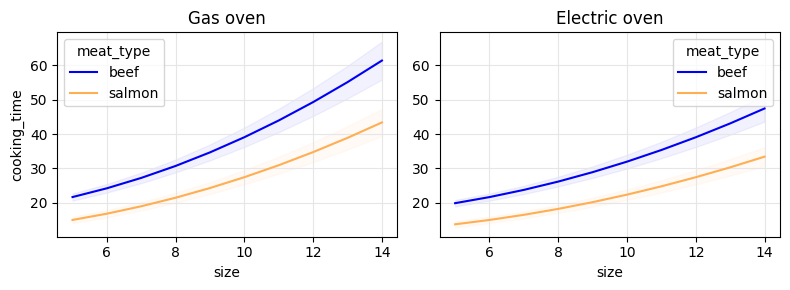

In [17]:
fig = ex4.plot_variables('cooking_time', 
                         distribution_var='seed',
                         oven_type=['gas', 'electric'],
                         meat_type=['beef', 'salmon'],
                         size=np.arange(5, 15),
                         seed=[10, 11, 12, 13, 14],
                  )
ax1, ax2 = fig.axes
ax1.get_shared_y_axes().join(ax1, ax2)
ax1.autoscale()
ax1.set_title('Gas oven')
ax2.set_title('Electric oven')


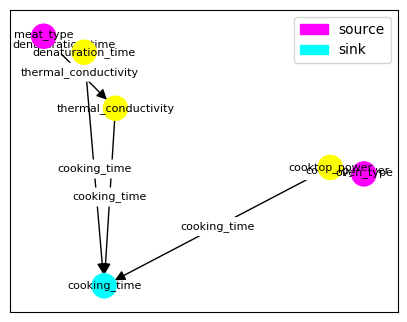

In [15]:
_ = ex4.draw_dependency_graph(figsize=(5,4))